In [38]:
import numpy as np
import pickle as pkl
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn   
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def load_data(path):
    with open(path, 'rb') as f:
        data = pkl.load(f)
    return data

# Load the data
Interaction_matrices = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_interaction_matrices_10binned.pkl')
spectral_data = load_data('/Users/sanazkazeminia/Documents/Mass_Spec_project/Mass_Spec_ML_Project/binary_spectra_dataset_10binned.pkl')

print(Interaction_matrices.shape)
print(spectral_data.shape)

cpu
torch.Size([100000, 6, 6])
torch.Size([100000, 2001])


In [116]:
import random

# Set a random seed for reproducibility 
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [117]:
print(Interaction_matrices[0].shape)
print(spectral_data[0].shape)
print(Interaction_matrices.shape)
print(spectral_data.shape)

torch.Size([6, 6])
torch.Size([2001])
torch.Size([100000, 6, 6])
torch.Size([100000, 2001])


In [133]:
for matrix in Interaction_matrices: # forgot to zero out the diagonal
    matrix[0,0] = 0

tensor([[0., 1., 1., 0., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 0., 0.],
        [1., 0., 0., 1., 0., 1.]])


tensor([[1., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1.],
        [1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.]])


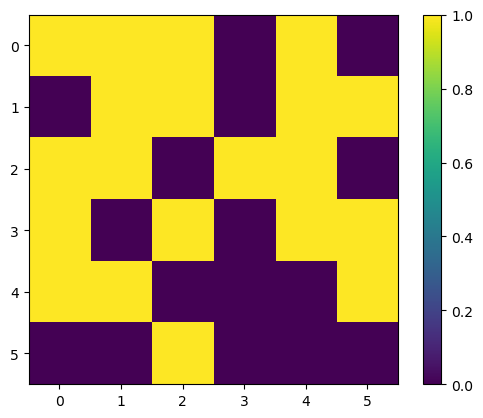

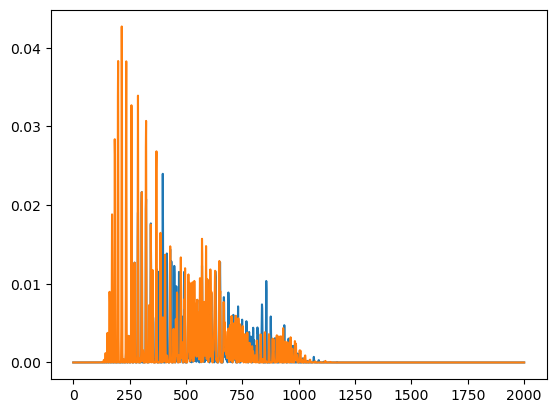

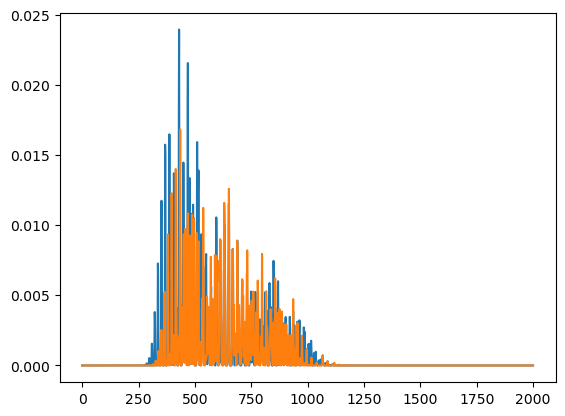

In [118]:
import matplotlib.pyplot as plt

# Plot the first interaction matrix and the first 4 spectras just to make sure. 
print(Interaction_matrices[1])
plt.imshow(Interaction_matrices[1], cmap='viridis', interpolation='nearest')
colorbar = plt.colorbar()
plt.show()

plt.plot(spectral_data[1]) 
plt.plot(spectral_data[2])
plt.show()
plt.plot(spectral_data[3]) 
plt.plot(spectral_data[4])
plt.show()

In [119]:
# flattening and stacking interaction matrices
flattened_matrices = [matrix.flatten() for matrix in Interaction_matrices] # storing in an array
flattened_matrices = torch.stack(flattened_matrices) # stacking the array
print(flattened_matrices.shape)
print(flattened_matrices[0]) # example to see the shape


torch.Size([100000, 36])
tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.])


In [120]:
X_spec = torch.tensor(spectral_data, dtype=torch.float32)
Y_matr = torch.tensor(flattened_matrices, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_spec, Y_matr, test_size=0.2, random_state=42) # spectra = x
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.8, random_state=42)


/var/folders/02/fvfmdq_j709g1tthj47t5fcm0000gn/T/ipykernel_80471/3949975714.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_spec = torch.tensor(spectral_data, dtype=torch.float32)
/var/folders/02/fvfmdq_j709g1tthj47t5fcm0000gn/T/ipykernel_80471/3949975714.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_matr = torch.tensor(flattened_matrices, dtype=torch.float32)


In [121]:
import torch 
from torch.utils.data import DataLoader, TensorDataset

# spectra = X
X_train = torch.Tensor(X_train).to(device)
X_test = torch.Tensor(X_test).to(device)
X_val = torch.Tensor(X_val).to(device)

# interaction matrices = y
y_val= torch.Tensor(y_val).to(device)
y_train = torch.Tensor(y_train).to(device)
y_test = torch.Tensor(y_test).to(device)


batch_size = 512 ## 512 is a good number for now. ?? 256 also worked well.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [122]:
import torch.nn as nn

class SpectralNet(nn.Module):
    def __init__(self):
        super(SpectralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2001, 1024), # 2001 is the number of features in the spectra data
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Added layer
            nn.ReLU(),  # Added activation function
            nn.Linear(128, 36), # 36 is the number of features in the flattened interaction matrix (multilabel classification)
            nn.Sigmoid() # sigmoid activation function for multilabel classification 
        )
    def forward(self, x):
        return self.model(x)
    


In [126]:
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR

model = SpectralNet().to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.00001) # lr = 0.001 works well
scheduler = CyclicLR(optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=2000, mode='triangular')

criterion = nn.BCELoss() # Binary Cross Entropy Loss for multilabel classification (now labels binary)


SpectralNet(
  (model): Sequential(
    (0): Linear(in_features=2001, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=36, bias=True)
    (12): Sigmoid()
  )
)


In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score



def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, threshold=0.5):
    train_epoch_losses = []
    val_epoch_losses = []

    for epoch in range(num_epochs):
        # Training the model
        model.train()
        train_loss = 0.0
        
        for batch in train_loader:
            X, y = batch
            optimizer.zero_grad()
            y_pred = model(X) # taking in X and predicting y - where X is the spectra data
            loss = criterion(y_pred, y) # calculating the loss based on the labels
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        average_train_loss = train_loss / len(train_loader)
        train_epoch_losses.append(average_train_loss)
    
        
        model.eval()
        val_loss = 0.0
        average_val_loss = 0
        all_val_preds = []
        true_val_labels = []
        with torch.no_grad():

            for batch in val_loader:
                X, y = batch
                y_pred = model(X)
                loss = criterion(y_pred, y)

                val_loss += loss.item()
                all_val_preds.append(y_pred.cpu().numpy()) # appending the predictions to a list
                true_val_labels.append(y.cpu().numpy()) # appending the true labels to a list

        average_val_loss = val_loss / len(val_loader)
        val_epoch_losses.append(average_val_loss)

        all_val_preds = np.vstack(all_val_preds) # stacking the predictions
        true_val_labels = np.vstack(true_val_labels) # stacking the true labels

        if epoch % 20 == 0:
            val_precisions = []
            val_recalls = []
            f1_scores = []
            accuracy_scores = []
            for i in range(36):
                    val_preds_binary = [1 if pred >= threshold else 0 for pred in all_val_preds[:, i]]
            
            val_precisions.append(precision_score(true_val_labels[:, i], val_preds_binary))
            val_recalls.append(recall_score(true_val_labels[:, i], val_preds_binary))
            f1_scores.append(f1_score(true_val_labels[:, i], val_preds_binary))
            accuracy_scores.append(accuracy_score(true_val_labels[:, i], val_preds_binary))

            precision = np.mean(val_precisions)
            recall = np.mean(val_recalls)
            macro_f1 = np.mean(f1_scores)
            accuracy = np.mean(accuracy_scores)

            print(f"precision_score: {precision}, recall_score: {recall}, f1_score: {macro_f1}, accuracy: {accuracy}")


        print(f"Epoch [{epoch+1}/{num_epochs}], average training Loss: {average_train_loss:.4f}, average validation Loss: {average_val_loss:.4f}")



        wandb.log({
            "epoch": epoch + 1, 
            "average train_loss": average_train_loss, 
            "average val_loss": average_val_loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": macro_f1
            })

        if (epoch + 1) % 10 == 0:
            state = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'loss': train_loss
            }
            torch.save(state, "binary_model_ANN.pth") ## save the model every 100 epochs
            print("Saved model to:", "binary_model_ANN.pth")
    
    return model, train_epoch_losses, val_epoch_losses, all_val_preds, true_val_labels

        


In [128]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Binary_ANN_Project",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.00001,
    "architecture": "ANN",
    "dataset": "binary_10binned",
    "epochs": 400,
    "batch_size": 512,
    "learning_rate_scheduler": "CyclicLR",
    "step_size_up": 2000,
    "optimizer": "Adam",
    "loss_function": "BCELoss",
    })

num_epochs = 500
# 0.01 is terrible - 0.001 is better - cyclic is better
Initial_Model = train(model, train_loader, val_loader, optimizer, criterion, num_epochs, threshold=0.5)

accuracy,▅▅▇▇▅▅▄▄▆▆▅▅▂▂▁▁▃▃▄▄▄▄▂▂▅▅▆▆██████████▇▇
average train_loss,██████▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
average val_loss,▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,██▆▆▃▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▂▂▂▂
precision,▅▅▆▆▅▅▄▄▆▆▅▅▂▂▁▁▃▃▄▄▄▄▂▂▅▅▆▆██████████▇▇
recall,██▅▅▃▃▂▂▁▁▁▁▁▁▁▁▂▂▁▁▂▂▂▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▁▁
accuracy,0.50294
average train_loss,0.594
average val_loss,0.80755
epoch,400


precision_score: 0.4988733663812528, recall_score: 0.13782370517928286, f1_score: 0.21597892888498682, accuracy: 0.4976875
Epoch [1/500], average training Loss: 0.7000, average validation Loss: 0.6965
Epoch [2/500], average training Loss: 0.6994, average validation Loss: 0.6961
Epoch [3/500], average training Loss: 0.6989, average validation Loss: 0.6957
Epoch [4/500], average training Loss: 0.6985, average validation Loss: 0.6955
Epoch [5/500], average training Loss: 0.6982, average validation Loss: 0.6953
Epoch [6/500], average training Loss: 0.6979, average validation Loss: 0.6951
Epoch [7/500], average training Loss: 0.6977, average validation Loss: 0.6949
Epoch [8/500], average training Loss: 0.6974, average validation Loss: 0.6948
Epoch [9/500], average training Loss: 0.6972, average validation Loss: 0.6947
Epoch [10/500], average training Loss: 0.6970, average validation Loss: 0.6946
Saved model to: binary_model_ANN.pth
Epoch [11/500], average training Loss: 0.6968, average vali

In [129]:
epoch_loss = 0
y_pred = []
y_true = []


model.eval()
for xt, yt in test_loader:
    with torch.no_grad():
            outputs= model(xt)
            print('output ', outputs.size())
            print('matrices ', yt.size())
            loss = criterion(outputs, yt)
            epoch_loss += loss.item()
            y_true.extend(yt)
            y_pred.extend(outputs)
            epoch_loss /= len(test_loader)
    
print(f"Validation Loss: {epoch_loss:.4f}")


y_true = torch.stack(y_true) # for converting the list to a tensor 
y_pred = torch.stack(y_pred)


output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([512, 36])
matrices  torch.Size([512, 36])
output  torch.Size([416, 36])
matrices  torch.Size([416, 36])
Validation Loss: 0.0991


torch.Size([4000, 36])
torch.Size([4000, 36])


tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.])
tensor([0.4673, 0.4986, 0.4931, 0.4795, 0.5164, 0.5109, 0.5077, 0.4794, 0.4768,
        0.5348, 0.5114, 0.5133, 0.4954, 0.4705, 0.5205, 0.5035, 0.5167, 0.4939,
        0.5038, 0.5221, 0.4797, 0.4781, 0.5074, 0.4970, 0.4943, 0.4966, 0.4827,
        0.4965, 0.5021, 0.4976, 0.4825, 0.5041, 0.5001, 0.4900, 0.4926, 0.5237])


Running simulator at 1715806958.8424408
Finished simulator at 1715806958.8844101


tensor([[1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0]])


torch.Size([2001])


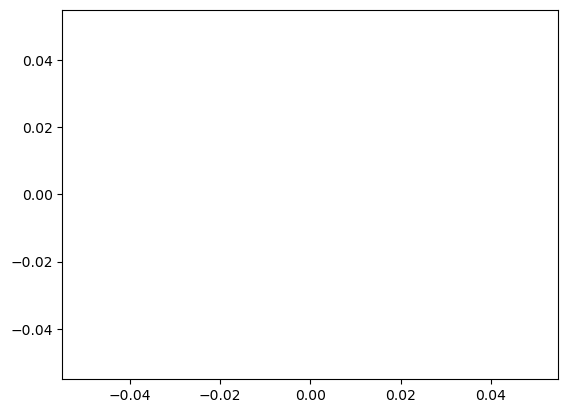